# Aula 14 - Vieses em Sistemas de Recomendação - Exercícios

In [23]:
import subprocess
import sys
import pandas as pd
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

# Garante que o pacote scikit-surprise esteja disponível no ambiente local
try:
    import surprise  # type: ignore
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-surprise", "--quiet"])

from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic

## Vídeos de Apoio

https://www.youtube.com/watch?v=OSv5J1EVEqA

https://www.youtube.com/watch?v=abGCaK86tY4


## Exercícios de Vieses

### Download do Dataset

In [24]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv  -O ./steam-200k.csv

--2025-12-01 21:53:51--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 2268468 (2,2M) [text/plain]
Salvando em: ‘./steam-200k.csv’

./steam-200k.csv      0%[                    ]       0  --.-KB/s               200 OK
Tamanho: 2268468 (2,2M) [text/plain]
Salvando em: ‘./steam-200k.csv’

./steam-200k.csv    100%[===================>]   2,16M  7,67MB/s    em 0,3s    

2025-12-01 21:53:52 (7,67 MB/s) - ‘./steam-200k.csv’ salvo [2268468/2268468]

./steam-200k.csv    100%[===================>]   2,16M  7,67MB/s    em 0,3s    

2025-12-01 21:53:52 (7,67 MB/s) - ‘./steam-200k.csv’ salvo [2268468/2268468]



### Funções comuns

In [25]:
df = pd.read_csv("./steam-200k.csv")
df['hours_played'] = np.log10(df['hours_played'])/np.log10(df['hours_played']).max()
df['user_id'] = df['user_id'].astype(str)
df.head()

train, test = train_test_split(df, test_size=.3, random_state=42)

soma_interacoes_por_jogo = train.groupby('game_title').count()[['hours_played']]
soma_interacoes_por_jogo.columns = ['interactions']

map_soma = soma_interacoes_por_jogo.to_dict()['interactions']

soma_interacoes_por_jogo.head(5)

soma_interacoes_por_jogo_ordenado = soma_interacoes_por_jogo.sort_values('interactions', ascending=False)

map_id = dict(list(enumerate(soma_interacoes_por_jogo_ordenado.index)))
map_id = {v:k for k,v in map_id.items()}

jogos_maior_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[:11, 0]
jogos_menor_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[-2680:, 0]

jogos_entre_os_20porcento = set(df['game_title']) - set(jogos_maior_20porcento_nome) - set(jogos_menor_20porcento_nome)

reader = Reader(rating_scale=(float(train['hours_played'].min()), float(train['hours_played'].max())))
steam_data = Dataset.load_from_df(train[['user_id', 'game_title', 'hours_played']], reader)
steam_trainset = steam_data.build_full_trainset()

In [6]:
block_buster_group = []
niche_group = []
diverse_group = []

for user_id in train['user_id'].unique():
    interacted_by_user = train[train['user_id'] == user_id]
    high_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_maior_20porcento_nome)]
    lowest_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_menor_20porcento_nome)]

    if len(high_pop)/len(interacted_by_user) > 0.5:
        block_buster_group.append(user_id)
    elif len(lowest_pop)/len(interacted_by_user) > 0.5:
        niche_group.append(user_id)
    else:
        diverse_group.append(user_id)


In [7]:
group_sizes = pd.Series({
    'block_buster': len(block_buster_group),
    'niche': len(niche_group),
    'diverse': len(diverse_group)
}, name='usuarios_por_grupo')
group_sizes

block_buster    4051
niche            418
diverse         4782
Name: usuarios_por_grupo, dtype: int64

In [8]:
def calculate_gap_profile(train_df, user_id):
    """Calcula a média de interações (gap) dos itens consumidos pelo usuário."""
    user_items = train_df[train_df['user_id'] == user_id]['game_title'].values
    if len(user_items) == 0:
        return np.nan
    gap = sum(map_soma.get(item, 0) for item in user_items)
    return gap / len(user_items)

In [9]:
gap_bb_profile = np.mean([calculate_gap_profile(train, i) for i in block_buster_group])
gap_n_profile = np.mean([calculate_gap_profile(train, i) for i in niche_group])
gap_d_profile = np.mean([calculate_gap_profile(train, i) for i in diverse_group])
gap_bb_profile, gap_n_profile, gap_d_profile

(2446.012039943106, 24.848950535626805, 275.0942722204991)

In [ ]:
def item_is_relevant(user_id, item_id):
    aux = df[df["user_id"] == user_id]
    if item_id in list(aux['game_title']):
        return True
    return False

def calculate_MRR(map_recommendations):

    MRR = 0
    for user_id in map_recommendations:
        user_find_corerect_item = False
        for index, (item, score) in enumerate(map_recommendations[user_id]):
            if user_find_corerect_item is False:
                if item_is_relevant(user_id, item):
                    MRR += (1/(index+1))
                    user_find_corerect_item = True
        
    return MRR/len(map_recommendations)


def calculate_gap(list_items):
    gap = sum([map_soma.get(i, 0) for i in list_items])
    return gap/len(list_items)

def calculate_gap_groups(predictions):
    gap_bb_rec1 = 0
    gap_d_rec1 = 0
    gap_n_rec1 = 0

    n_bb, n_d, n_n = 0, 0, 0

    for user, reclist in zip(test['user_id'].unique()[:200], predictions):
        if user in block_buster_group:
            n_bb += 1
            gap_bb_rec1 += calculate_gap([i[0] for i in predictions[reclist]])
        elif user in niche_group:
            n_n += 1
            gap_n_rec1 += calculate_gap([i[0] for i in predictions[reclist]])
        else:
            n_d += 1
            gap_d_rec1 += calculate_gap([i[0] for i in predictions[reclist]])

    gap_bb_rec1 = gap_bb_rec1/n_bb
    gap_d_rec1 = gap_d_rec1/n_d
    gap_n_rec1 = gap_n_rec1/n_n
    
    delta_gab_bb = (gap_bb_rec1 - gap_bb_profile )/gap_bb_profile
    delta_gab_d = (gap_d_rec1 - gap_d_profile )/gap_d_profile
    delta_gab_n = (gap_n_rec1 - gap_n_profile )/gap_n_profile
    
    return delta_gab_bb, delta_gab_d, delta_gab_n

def build_prediction_cache(model):
    """Executa o modelo uma única vez e guarda as predições completas por usuário."""
    prediction_cache = {}
    catalog = list(df['game_title'].unique())
    for user in test['user_id'].unique()[:200]:
        user_testset_df = pd.DataFrame({"game_title": catalog})
        user_testset_df["hours_played"] = 0.0
        user_testset_df["user_id"] = user
        testset = (
            Dataset.load_from_df(
                user_testset_df[["user_id", "game_title", "hours_played"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        pred_list = model.test(testset)
        prediction_cache[user] = [(pred.iid, pred.est) for pred in pred_list if pred.uid == user]
    return prediction_cache

def get_recommendation(model, alpha=0.5, prediction_cache=None):
    
    prediction_cache = prediction_cache or build_prediction_cache(model)
    prediction_user_map = {}
    prediction_user_map_corrected = {}
    
    for user, preds in prediction_cache.items():
        base_sorted = sorted(preds, key=lambda x: x[1], reverse=True)[:10]
        prediction_user_map[user] = base_sorted
        corrected_scores = []
        for item, score in preds:
            popularity_term = 1 / np.log(map_soma.get(item, 1) + 1)
            corrected_scores.append((item, (1 - alpha) * score + alpha * popularity_term))
        prediction_user_map_corrected[user] = sorted(corrected_scores, key=lambda x: x[1], reverse=True)[:10]
    
    return prediction_user_map, prediction_user_map_corrected

In [11]:
def summarize_gap_by_group(prediction_user_map):
    """Retorna o gap médio recomendado para cada grupo de usuário."""
    def _mean_gap(user_ids):
        gaps = []
        for user in user_ids:
            recs = prediction_user_map.get(user, [])
            if not recs:
                continue
            rec_items = [item for item, _ in recs]
            gaps.append(calculate_gap(rec_items))
        return float(np.mean(gaps)) if gaps else np.nan

    return {
        'gap_block_buster': _mean_gap(block_buster_group),
        'gap_niche': _mean_gap(niche_group),
        'gap_diverse': _mean_gap(diverse_group)
    }


def collect_popularity_samples(prediction_user_map, model_name, variant_name):
    rows = []
    for user, recs in prediction_user_map.items():
        for item, _ in recs:
            popularity = map_soma.get(item, 0)
            rows.append({
                'model': model_name,
                'variant': variant_name,
                'popularity': popularity,
                'popularity_log1p': np.log1p(popularity)
            })
    return rows

***Exercício 01:*** Explore como outros modelos se comportam em relação ao viés de popularidade. Tente visualizar a distribuição das recomendações e as métricas estudadas.

Computing the pearson similarity matrix...
Done computing similarity matrix.


,model,variant,MRR,gap_block_buster,gap_niche,gap_diverse
0,SVD,Base,0.053861,43.250,61.76,60.617308
1,SVD,Alpha=0.5,0.004464,1.000,1.00,1.000000
2,KNN-item,Base,0.016083,26.625,19.45,17.201923
3,KNN-item,Alpha=0.5,0.140000,1.250,1.11,1.107051


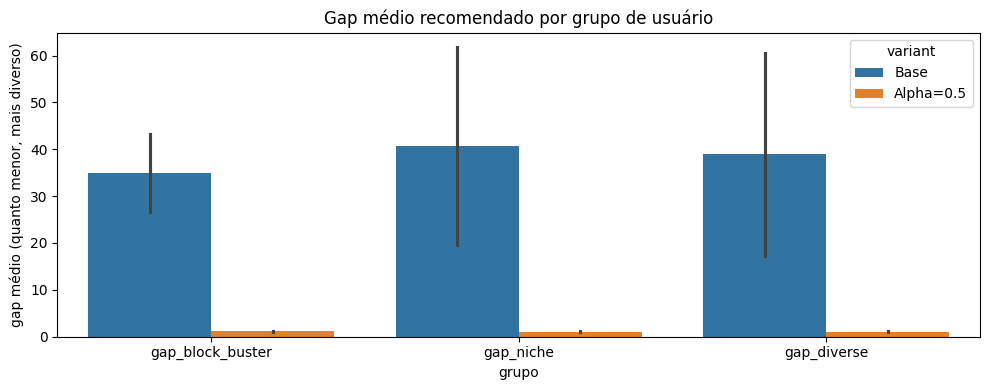

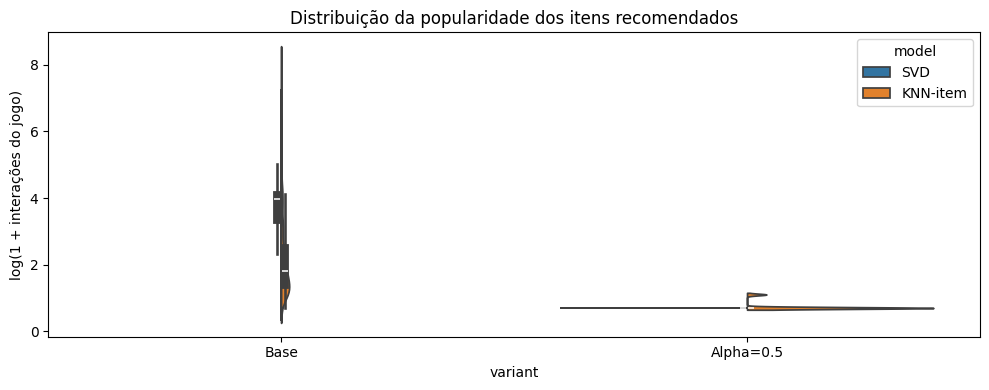

In [ ]:
from IPython.display import display

steam_models = {
    'SVD': SVD(random_state=42, n_factors=50),
    'KNN-item': KNNBasic(sim_options={'name': 'pearson', 'user_based': False})
}

model_metrics = []
popularity_rows = []

for model_name, algo in steam_models.items():
    algo.fit(steam_trainset)
    prediction_cache = build_prediction_cache(algo)
    raw_predictions, corrected_predictions = get_recommendation(algo, alpha=0.5, prediction_cache=prediction_cache)

    for variant_name, prediction_map in [('Base', raw_predictions), ('Alpha=0.5', corrected_predictions)]:
        gap_summary = summarize_gap_by_group(prediction_map)
        model_metrics.append({
            'model': model_name,
            'variant': variant_name,
            'MRR': calculate_MRR(prediction_map),
            **gap_summary
        })
        popularity_rows.extend(collect_popularity_samples(prediction_map, model_name, variant_name))

metrics_df = pd.DataFrame(model_metrics)
display(metrics_df)

gap_cols = ['gap_block_buster', 'gap_niche', 'gap_diverse']
gap_long = metrics_df.melt(id_vars=['model', 'variant'], value_vars=gap_cols, var_name='grupo', value_name='gap_medio')
plt.figure(figsize=(10, 4))
sns.barplot(data=gap_long, x='grupo', y='gap_medio', hue='variant')
plt.title('Gap médio recomendado por grupo de usuário')
plt.ylabel('gap médio (quanto menor, mais diverso)')
plt.tight_layout()
plt.show()

popularity_df = pd.DataFrame(popularity_rows)
plt.figure(figsize=(10, 4))
sns.violinplot(data=popularity_df, x='variant', y='popularity_log1p', hue='model', split=True)
plt.ylabel('log(1 + interações do jogo)')
plt.title('Distribuição da popularidade dos itens recomendados')
plt.tight_layout()
plt.show()

***Exercício 02:*** Qual o efeito provocado pela variação do parâmetro $\alpha$? Demonstre como variam as métricas de acurácia e viés de popularidade com a variação do parâmetro.

,alpha,MRR,gap_block_buster,gap_niche,gap_diverse
0,0.0,0.053861,43.25,61.76,60.617308
1,0.2,0.009464,1.00,2.30,1.622436
2,0.4,0.004464,1.00,1.00,1.000000
3,0.6,0.004464,1.00,1.00,1.000000
4,0.8,0.004464,1.00,1.00,1.000000
5,1.0,0.003056,1.00,1.00,1.000000


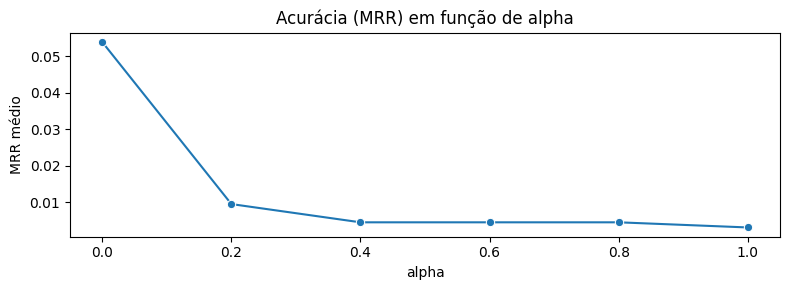

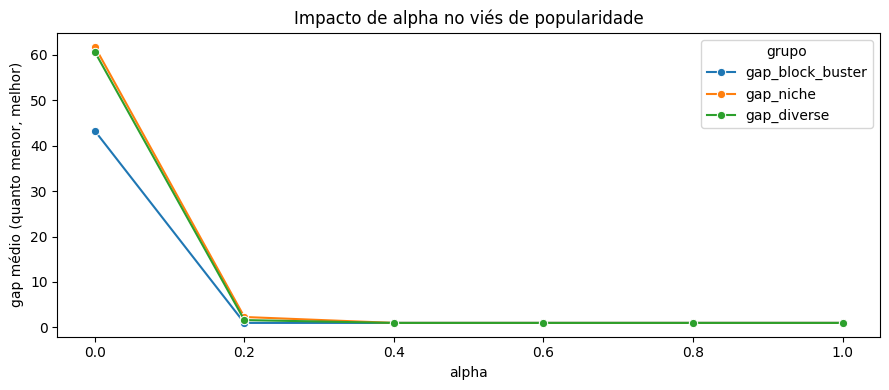

In [ ]:
alpha_values = np.linspace(0.0, 1.0, 6)
base_model = SVD(random_state=42, n_factors=50)
base_model.fit(steam_trainset)
prediction_cache = build_prediction_cache(base_model)

alpha_metrics = []
for alpha in alpha_values:
    _, corrected_predictions = get_recommendation(base_model, alpha=alpha, prediction_cache=prediction_cache)
    gap_summary = summarize_gap_by_group(corrected_predictions)
    alpha_metrics.append({
        'alpha': alpha,
        'MRR': calculate_MRR(corrected_predictions),
        **gap_summary
    })

alpha_df = pd.DataFrame(alpha_metrics)
display(alpha_df)

plt.figure(figsize=(8, 3))
sns.lineplot(data=alpha_df, x='alpha', y='MRR', marker='o')
plt.title('Acurácia (MRR) em função de alpha')
plt.ylabel('MRR médio')
plt.tight_layout()
plt.show()

gap_cols = ['gap_block_buster', 'gap_niche', 'gap_diverse']
gap_long = alpha_df.melt(id_vars='alpha', value_vars=gap_cols, var_name='grupo', value_name='gap_medio')
plt.figure(figsize=(9, 4))
sns.lineplot(data=gap_long, x='alpha', y='gap_medio', hue='grupo', marker='o')
plt.title('Impacto de alpha no viés de popularidade')
plt.ylabel('gap médio (quanto menor, melhor)')
plt.tight_layout()
plt.show()

## Exercícios de Fairness

In [26]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat  -O ./ratings.dat
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat  -O ./movies.dat

--2025-12-01 21:55:39--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 4318513 (4,1M) [text/plain]
Salvando em: ‘./ratings.dat’

./ratings.dat         0%[                    ]       0  --.-KB/s               200 OK
Tamanho: 4318513 (4,1M) [text/plain]
Salvando em: ‘./ratings.dat’

./ratings.dat       100%[===================>]   4,12M  8,42MB/s    em 0,5s    

2025-12-01 21:55:40 (8,42 MB/s) - ‘./ratings.dat’ salvo [4318513/4318513]

./ratings.dat       100%[===================>]   4,12M  8,42MB/s    em 0,5s    

2025-12-01 21:55:40 (8,42 MB/s) - ‘./ratings.dat’ salvo [4318513/4318513]

--2025-12-01 21:55:40--  https://raw.githubuse

In [27]:
df = pd.read_csv("./ratings.dat", sep=",")
df_genres = pd.read_csv(
    "./movies.dat",
    sep="::",
    names=['item', 'title', 'genres'],
    engine='python',
    encoding='latin-1'
 )
train, test = train_test_split(df, test_size=.3, random_state=42)
genre_map = {i['item']:i['genres'].split("|") for i in df_genres[['item', 'genres']].to_dict('records')}

reader = Reader(rating_scale=(float(df['rating'].min()), float(df['rating'].max())))
movie_data = Dataset.load_from_df(train[['user', 'item', 'rating']], reader)
movie_trainset = movie_data.build_full_trainset()

### Funções Comuns

In [28]:
def get_user_recommendation_distribution(prediction_user_map):
    user_rec_distribution = {}
    n = 0
    for (item, score) in prediction_user_map:
        for genre in genre_map[item]:
            if genre not in user_rec_distribution:
                user_rec_distribution[genre] = 0
            n += 1
            user_rec_distribution[genre] += 1
            
    user_rec_distribution = {k: v/n for k, v in sorted(user_rec_distribution.items(), key=lambda item: item[1])}
    return user_rec_distribution


def user_rank_miscalibration(user_profile_dist, rec_profile_dist, alpha=0.001):
    p_g_u = user_profile_dist
    q_g_u = rec_profile_dist
    
    Ckl = 0
    for genre, p in p_g_u.items():
        q = q_g_u.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if til_q == 0 or p_g_u.get(genre, 0) == 0:
            Ckl = Ckl
        else:
            Ckl += p * np.log2(p / til_q)
    return Ckl

def get_mean_rank_miscalibration(predictions):
    
    MRMC = 0
    
    for user in predictions:
        RMC = 0
        user_profile_dist = get_user_profile_distribution(train, user)
        if user_profile_dist == {}:
            continue
        
        void = user_rank_miscalibration(user_profile_dist, {})
        N = len(predictions[user])
        for i in range(1, N):
            user_rec_dist = get_user_recommendation_distribution(predictions[user][:i])
            kl = user_rank_miscalibration(user_profile_dist, user_rec_dist)
            RMC += kl/void

        MRMC += RMC/N
    
    return MRMC/len(predictions)

def get_recommendation_raw(model):
    
    prediction_user_map = {}

    for user in test['user'].unique()[:200]:

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        
        pred_list = model.test(testset)
        
        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        
        
        prediction_user_map[user] = predictions[:10]

                
    return prediction_user_map

def rerank_recommendation(profile_dist, list_recomended_items, user, N, tradeoff):
    re_ranked_list = []
    re_ranked_with_score = []
    
    for _ in range(N):
        
        max_mmr = -np.inf
        max_item = None
        max_item_rating = None
        
        for item, rating in list_recomended_items:
            if item in re_ranked_list:
                continue
                
            temporary_list = re_ranked_list + [item]
            temporary_list_with_score = re_ranked_with_score + [(item, rating)]
                
            weight_part = sum(
                recomendation[1]
                for recomendation in temporary_list_with_score
            )
            
            full_tmp_calib = calculate_calibration_sum(
                profile_dist,
                temporary_list_with_score,
                user
            )
            
            maximized = (1 - tradeoff)*weight_part - tradeoff*full_tmp_calib
            
            if maximized > max_mmr:
                max_mmr = maximized
                max_item = item
                max_item_rating = rating
            
        if max_item is not None:
            re_ranked_list.append(max_item)
            re_ranked_with_score.append((max_item, max_item_rating))
            
    return re_ranked_list, re_ranked_with_score  

def calculate_calibration_sum(profile_dist, temporary_list_with_score, user, alpha=0.001):
    kl_div = 0.0
    reco_distr = get_user_recommendation_distribution(temporary_list_with_score)
    for genre, p in profile_dist.items():
        q = reco_distr.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if p == 0.0 or til_q == 0.0:
            kl_div = kl_div
        else:
            kl_div = kl_div + (p * np.log2(p / til_q))
    return kl_div

def get_user_profile_distribution(df, user):
    user_profile_distribution = {}
    n = 0
    for item in df[df['user'] == user]['item'].values:

        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1
            
    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    return user_profile_distribution


def get_recommendation_fairness(model, lambda_=0.5):
    
    prediction_user_map = {}

    for user in test['user'].unique()[:200]:
        
        user_profile_distribution = get_user_profile_distribution(train, user)

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        
        pred_list = model.test(testset)
        
        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        
        reranked_list = rerank_recommendation(
            user_profile_distribution,
            predictions[:100],
            user,
            10,
            lambda_
        )
        
        
        prediction_user_map[user] = reranked_list[1]

                
    return prediction_user_map

In [29]:
positive_items_by_user = (
    test[test['rating'] >= 4]
    .groupby('user')['item']
    .apply(set)
    .to_dict()
 )

def hit_rate_at_k(prediction_user_map, k=10):
    hits = []
    for user, recs in prediction_user_map.items():
        relevant = positive_items_by_user.get(user)
        if not relevant:
            continue
        recommended_items = [item for item, _ in recs[:k]]
        hits.append(int(len(relevant.intersection(recommended_items)) > 0))
    return float(np.mean(hits)) if hits else np.nan

def aggregate_genre_distribution(prediction_user_map):
    counts = {}
    total = 0
    for recs in prediction_user_map.values():
        for item, _ in recs:
            for genre in genre_map.get(item, []):
                counts[genre] = counts.get(genre, 0) + 1
                total += 1
    return {genre: count / total for genre, count in counts.items()} if total else {}

***Exercício 03:*** Explore como outros modelos se comportam com as injustiças relacionadas ao genero do filme. Visualize as métricas para diferentes modelos.

Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


,model,hit_rate@10,MRMC
0,SVD,0.158163,0.426159
1,KNN-user,0.015306,0.508537


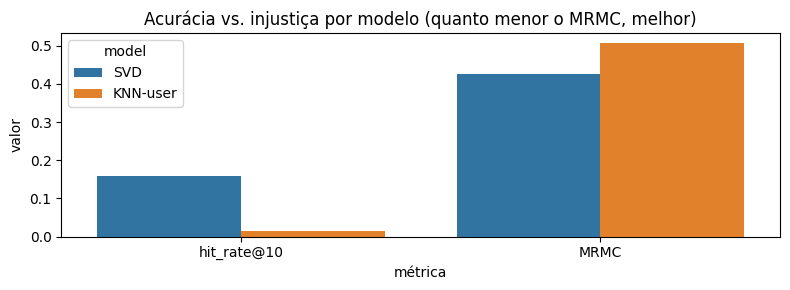

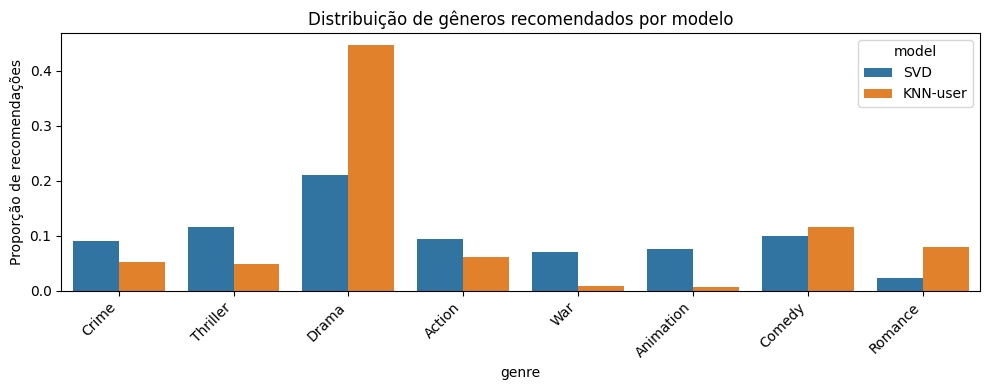

In [30]:
fairness_models = {
    'SVD': SVD(random_state=42, n_factors=60),
    'KNN-user': KNNBasic(sim_options={'name': 'pearson', 'user_based': True})
}

fairness_results = []
genre_rows = []

for model_name, algo in fairness_models.items():
    algo.fit(movie_trainset)
    prediction_map = get_recommendation_raw(algo)
    fairness_results.append({
        'model': model_name,
        'hit_rate@10': hit_rate_at_k(prediction_map),
        'MRMC': get_mean_rank_miscalibration(prediction_map)
    })
    genre_dist = aggregate_genre_distribution(prediction_map)
    for genre, share in genre_dist.items():
        genre_rows.append({'model': model_name, 'genre': genre, 'share': share})

fairness_df = pd.DataFrame(fairness_results)
display(fairness_df)

plt.figure(figsize=(8, 3))
sns.barplot(data=fairness_df.melt(id_vars='model', value_vars=['hit_rate@10', 'MRMC'], var_name='métrica', value_name='valor'),
            x='métrica', y='valor', hue='model')
plt.title('Acurácia vs. injustiça por modelo (quanto menor o MRMC, melhor)')
plt.tight_layout()
plt.show()

genre_df = pd.DataFrame(genre_rows)
top_genres = genre_df.groupby('genre')['share'].mean().sort_values(ascending=False).head(8).index
plt.figure(figsize=(10, 4))
sns.barplot(data=genre_df[genre_df['genre'].isin(top_genres)], x='genre', y='share', hue='model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Proporção de recomendações')
plt.title('Distribuição de gêneros recomendados por modelo')
plt.tight_layout()
plt.show()

***Exercício 04:*** Qual o efeito provocado pela variação do parâmetro $\lambda$ da calibração? Tente visualizar o efeito provocado nas métricas de fairness e acurácia se variarmos o parâmetro lambda.

,lambda,hit_rate@10,MRMC
0,0.00,0.158163,0.426159
1,0.25,0.168367,0.155257
2,0.50,0.193878,0.121502
3,0.75,0.234694,0.111216
4,1.00,0.219388,0.108658


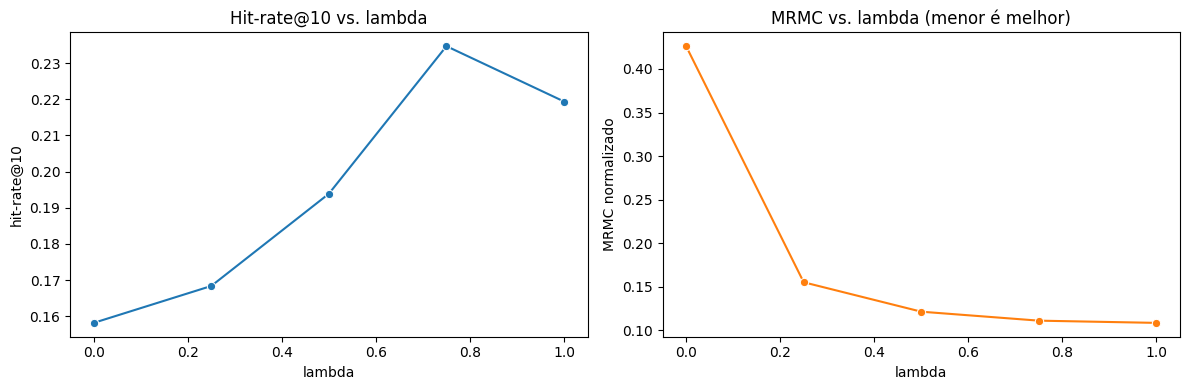

In [31]:
lambda_values = np.linspace(0.0, 1.0, 5)
calibration_model = SVD(random_state=42, n_factors=60)
calibration_model.fit(movie_trainset)

lambda_metrics = []
for lambda_value in lambda_values:
    reranked_predictions = get_recommendation_fairness(calibration_model, lambda_=lambda_value)
    lambda_metrics.append({
        'lambda': lambda_value,
        'hit_rate@10': hit_rate_at_k(reranked_predictions),
        'MRMC': get_mean_rank_miscalibration(reranked_predictions)
    })

lambda_df = pd.DataFrame(lambda_metrics)
display(lambda_df)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
sns.lineplot(ax=axes[0], data=lambda_df, x='lambda', y='hit_rate@10', marker='o', color='tab:blue')
axes[0].set_title('Hit-rate@10 vs. lambda')
axes[0].set_ylabel('hit-rate@10')
sns.lineplot(ax=axes[1], data=lambda_df, x='lambda', y='MRMC', marker='o', color='tab:orange')
axes[1].set_title('MRMC vs. lambda (menor é melhor)')
axes[1].set_ylabel('MRMC normalizado')
for ax in axes:
    ax.set_xlabel('lambda')
plt.tight_layout()
plt.show()